In [1]:
import os
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# master path
master_data = '../data'

In [3]:
# Load the data set
def isolate():
    global df
    
    data = []
    
    kinds = os.listdir(master_data)
    for kind in kinds:
        sub_categories = [path for path in os.listdir(f'{master_data}/{kind}')
                          if os.path.isdir(f'{master_data}/{kind}/{path}')]
        # ./Apple/Apple A -> sub_categories = ['Apple A']
        # ./Banana/71Banana02034.png -> sub_categories = []
        for sub_category in sub_categories:
            data += [[sub_category, path] for path in 
                     glob.glob(pathname=f'{master_data}/{kind}/{sub_category}/*.png')]
            continue
        
        data += [[kind, path] for path in glob.glob(pathname=f'{master_data}/{kind}/*.png')]
            
    df = pd.DataFrame(data=data, columns=['kind', 'path'])
    
isolate()

In [4]:
df_a = df.copy()
indicies = df_a[df_a['kind'] == 'Total Number of Apples'].index
df_a.drop(index=indicies, inplace=True)
indicies = df_a[df_a['kind'].isin(['Guava total', 'guava total final'])].index
df_a.drop(index=indicies, inplace=True)
indicies = df_a[df_a['kind'] == 'Total Number of Kiwi fruit'].index
df_a.drop(index=indicies, inplace=True)

df_b = df_a.copy()
df_b['kind'] = df_b['kind'].astype('category')
df_b = df_b.groupby(by='kind').sample(n=100, random_state=0).sample(frac=1, random_state=0)

In [5]:
preprocessor = tf.keras.models.load_model("../results/preprocessor.h5")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-11 18:26:28.507285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-11 18:26:28.507383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def load_images(df):
    paths = df['path'].values
    X = []
    
    for path in paths:
        raw = tf.io.read_file(path)
        img = tf.image.decode_png(raw, channels=3)
        img = preprocessor(img)
        X.append(img)
        
    y = df['kind'].cat.codes
    
    return np.array(X), tf.keras.utils.to_categorical(y)

In [7]:
X_inf, y_inf = load_images(df_b)

In [8]:
model = tf.keras.models.load_model("../results/seq_5.h5")
tf.keras.Sequential().pre
model.trainable = False

In [22]:
kinds = sorted(df_a['kind'].unique())
kinds_dict = dict(zip([i for i in range(len(kinds))], kinds))

In [23]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(kinds_dict[x.index(max(x))])
    return lst2

In [30]:
int_to_kinds = lambda items: [kinds_dict[item] for item in items]

In [32]:
y_inf_pred = int_to_kinds(np.argmax(model.predict(X_inf), axis=1))
y_inf_final = from_categorical(y_inf)

print(classification_report(y_inf_final, y_inf_pred))

72/72 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

     Apple A       0.95      0.81      0.88       100
     Apple B       0.84      0.96      0.90       100
     Apple C       0.91      0.95      0.93       100
     Apple D       1.00      0.95      0.97       100
     Apple E       0.89      0.89      0.89       100
     Apple F       0.72      0.87      0.79       100
      Banana       0.70      0.56      0.62       100
   Carambola       1.00      0.95      0.97       100
      Kiwi B       0.91      0.98      0.94       100
      Kiwi C       0.98      0.94      0.96       100
       Mango       0.77      0.87      0.82       100
      Orange       0.95      0.97      0.96       100
       Peach       0.92      0.83      0.87       100
        Pear       0.86      0.90      0.88       100
   Persimmon       0.96      0.93      0.94       100
      Pitaya       0.91      1.00      0.95       100
        Plum       1.00    

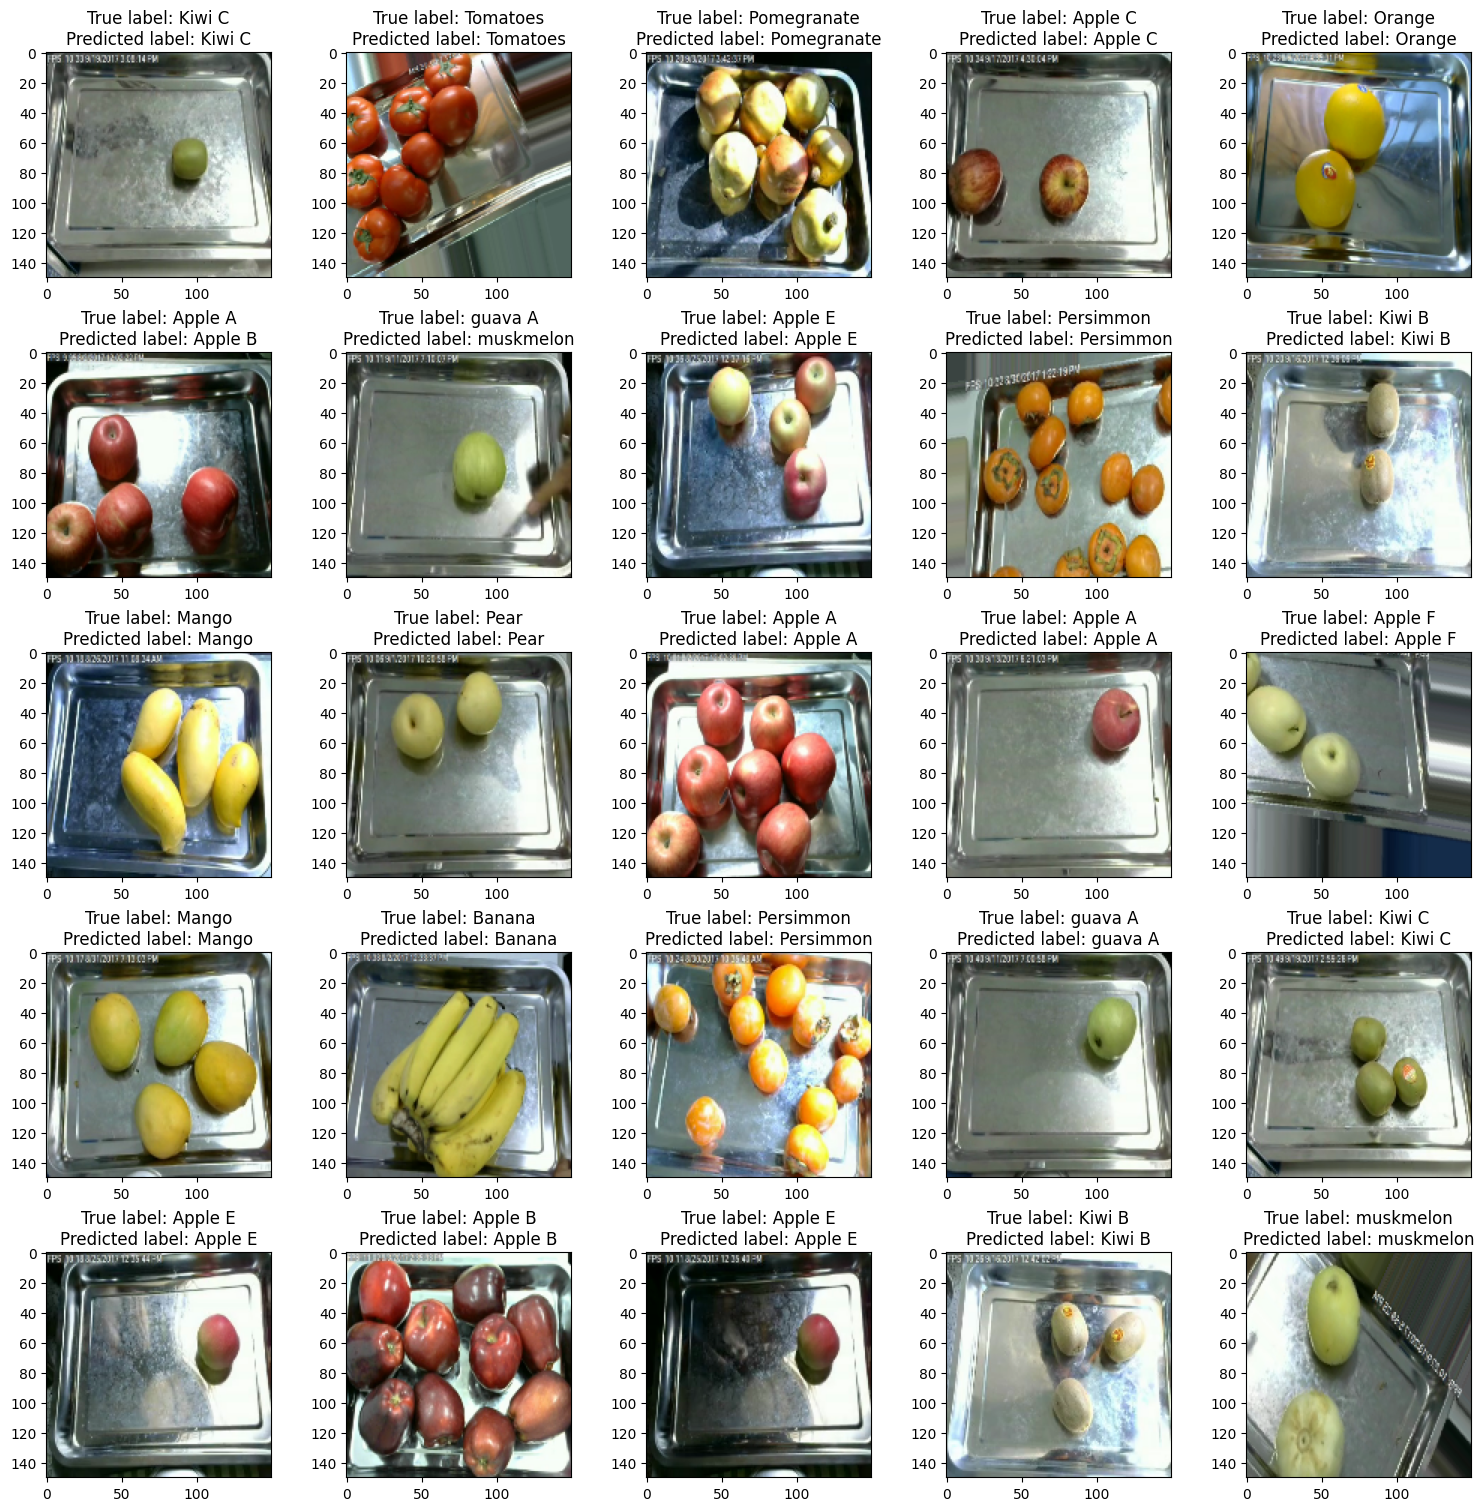

In [12]:
fig, axes = plt.subplots(5,5, layout="constrained", figsize=(15,15))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_inf[i])
    ax.set_title(f'True label: {kinds[y_inf_final[i]]}\nPredicted label: {kinds[y_inf_pred[i]]}')